# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

In questa esericitazione andremo a fare una simulazione di dinamica molecolare di particelle che sentono un potenziale che è quello di Lennard-Jones, e andremo a stimare le seguenti quantità:
- energia cinetica per particella: $$\frac{K}{N}=\frac{\sum_{i=1}^N\frac{p_i^2}{2m}}{N}$$
- energia potenziale per particella: $$\frac{U}{N}=\frac{V_{LJ}}{N}$$ dove $V_{LJ}$ è il potenziale di Lennard-Jones
- energia totale per particella: $$\frac{E}{N}=\frac{K}{N}+\frac{U}{N}$$
- temperatura: $$T=\frac{2}{3}\frac{K}{k_BN}$$
- pressione: $$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$
Nella nostra simulazione consideremo $108$ particelle, e useremo le unità di misura naturali, quindi prenderemo $k_B=1$, $m=1$, $\sigma=1$. Questo ci permette di eseguire una sola simulazione che rappresenta vari sistemi, e ci permette di ridurre gli errori.

### L'algoritmo di Verlet
L'algoritmo di Verlet è il metodo di integrazione delle equazioni del moto che useremo nella nostra simulazione. Due caratteristiche importanti sono che conserva energia e momento, ed è reversibile sotto inversione temporale. L'algoritmo è il seguente: $$\vec{r}(t+\delta t)\approx 2\vec{r}(t)-\vec{r}(t-\delta t)+\delta t^2\vec(a)(t)$$
Notiammo che la posizione al tempo $t+\delta t$ è calcolata dalla posizione al tempo $t$ e quella al tempo $t-\delta t$. Questo implica che per l'algoritmo di Verlet la posizione e la velocità iniziale non sono sufficienti a iniziare il calcolo. Inoltre, non usa le velocità per calcolare la posizione, ma è possibile ricavarla dalla traiettoria: $$\vec{v}(t)=\frac{\vec{r}(t+\delta t)-\vec{r}(t-\delta t)}{2\delta t}$$

### Condizioni al contorno
Un problema che è stato necessario risolvere è stato il fatto che è impossibile simulare un volume infinito, necessario per replicare le condizioni di sistema isolato e ideale, e, di conseguenza, per ovviare a ciò, si è fatto uso delle periodic boundary conditions. Applicare queste condizioni significa che quando una particella supera il limite creato dalla scatola, che è creata cubica, quindi con la stessa lunghezza $2L$ per tutti i lati, questa viene fatta ricomparire dal lato opposto della scatola, in questo modo la densità al centro rimane costante. Le coordinate di una particella in questo tipo di condizioni al contorno diventano quindi: $$x_i\quad\rightarrow\quad x_i-L\left[\frac{x_i}{L}\right]$$
Questo tipo di condizione al contorno funziona per i potenziali a breve range, come quello di Lennard-Jones, mentre non è adatta per potenziali a lungo range, questo poichè in questi ultimi ci saranno interazioni importanti tra una particella e le sue copie, che comporta quindi una sensibilità a una simmetria che nella realtà non esiste.

### Equilibrazione

Per equilibrare il sistema, oltre ad utilizzare le temperature scritte nel paragrafo 'Exercise 04', il procedimento è il seguente: si fa partire la simulazione con restart nel file di input a zero, una volta generati i dati, si prendono poi i file config.xyz e velocities.out e si copiano nell'input, in modo da far poi ripartire la simulazione con restart uguale a uno da questa configurazione.

Le simulazioni verranno fatte per le tre fasi: solida, liquida e gassosa, con i seguenti valori:
| Fase   | Densità $\rho^\star$ | Temperatura $T^\star$ | Raggio di Cut-off $r_c$ | Delta |
|--------|-----------------------|-----------------------|-------------------------|------|
| Solido | 1.1                   | 0.8                   | 2.2                     |0.008 |
| Liquido| 0.8                   | 1.1                   | 2.5                     |0.005 |
| Gas    | 0.05                  | 1.2                   | 5.0                     |0.0002|

### Convenzione dell'immagine minima
Questa convenzione è necessaria poichè dobbiamo includere le interazioni tra una molecola e tutte le altre nella nostra scatola, e le sue immagini, questo comporterebbe una somma su infiniti termini. Per ovviare a questo problema, per potenziali a breve range, possiamo restringere la somma facendo un'approssimazione: consideriamo una molecola a riposo al centro di una regione che ha la stessa grandezza e la stessa forma della nostra scatola. In questo modo la molecola $1$ interagisce con tutte le molecole i cui centri sono entro questa regione, cioè con le immagini periodiche più vicine delle altre $N-1$ molecole.
Un'altra approssimazione che viene fatta, per il calcolo del potenziale, è quella di applicare un raggio di cut-off sferico, che significa che oltre quel raggio il potenziale viene posto a zero. Per correggere l'errore dovuto a questa approssimazione verranno successivamente aggiunte delle correzioni di coda a determinate quantità.

### Exercise 04

Nella cella sottostante possiamo vedere le simulazioni coi valori sopra specificati, dove nei grafici è presente sulle $x$ il numero di blocchi, e sulle $y$ le varie quantità calcolate. Il tutto è in unità di misura naturali, questo diminuisce l'errore e permette di simulare più sistemi con un'unica simulazione.

La temperatura $T^*$ è quella a cui vogliamo che il nostro sistema si stabilizzi, ma non è quella da cui dobbiamo partire, infatti, partendo da quella il sistema si stabilizzerebbe a una temperatura diversa. Per ottenere i valori cercati, la simulazione è stata quindi fatta partire dalle seguenti temperature:
- $T=1.6$ nel solido, per arrivare a $T^*=0.8$
- $T=2$ nel liquido, per arrivare a $T^*=1.1$
- $T=1$ nel gas per arrivare a $T^*=1.2$

Per far partire la simulazione consideriamo la configurazione iniziale come quella cristallina.

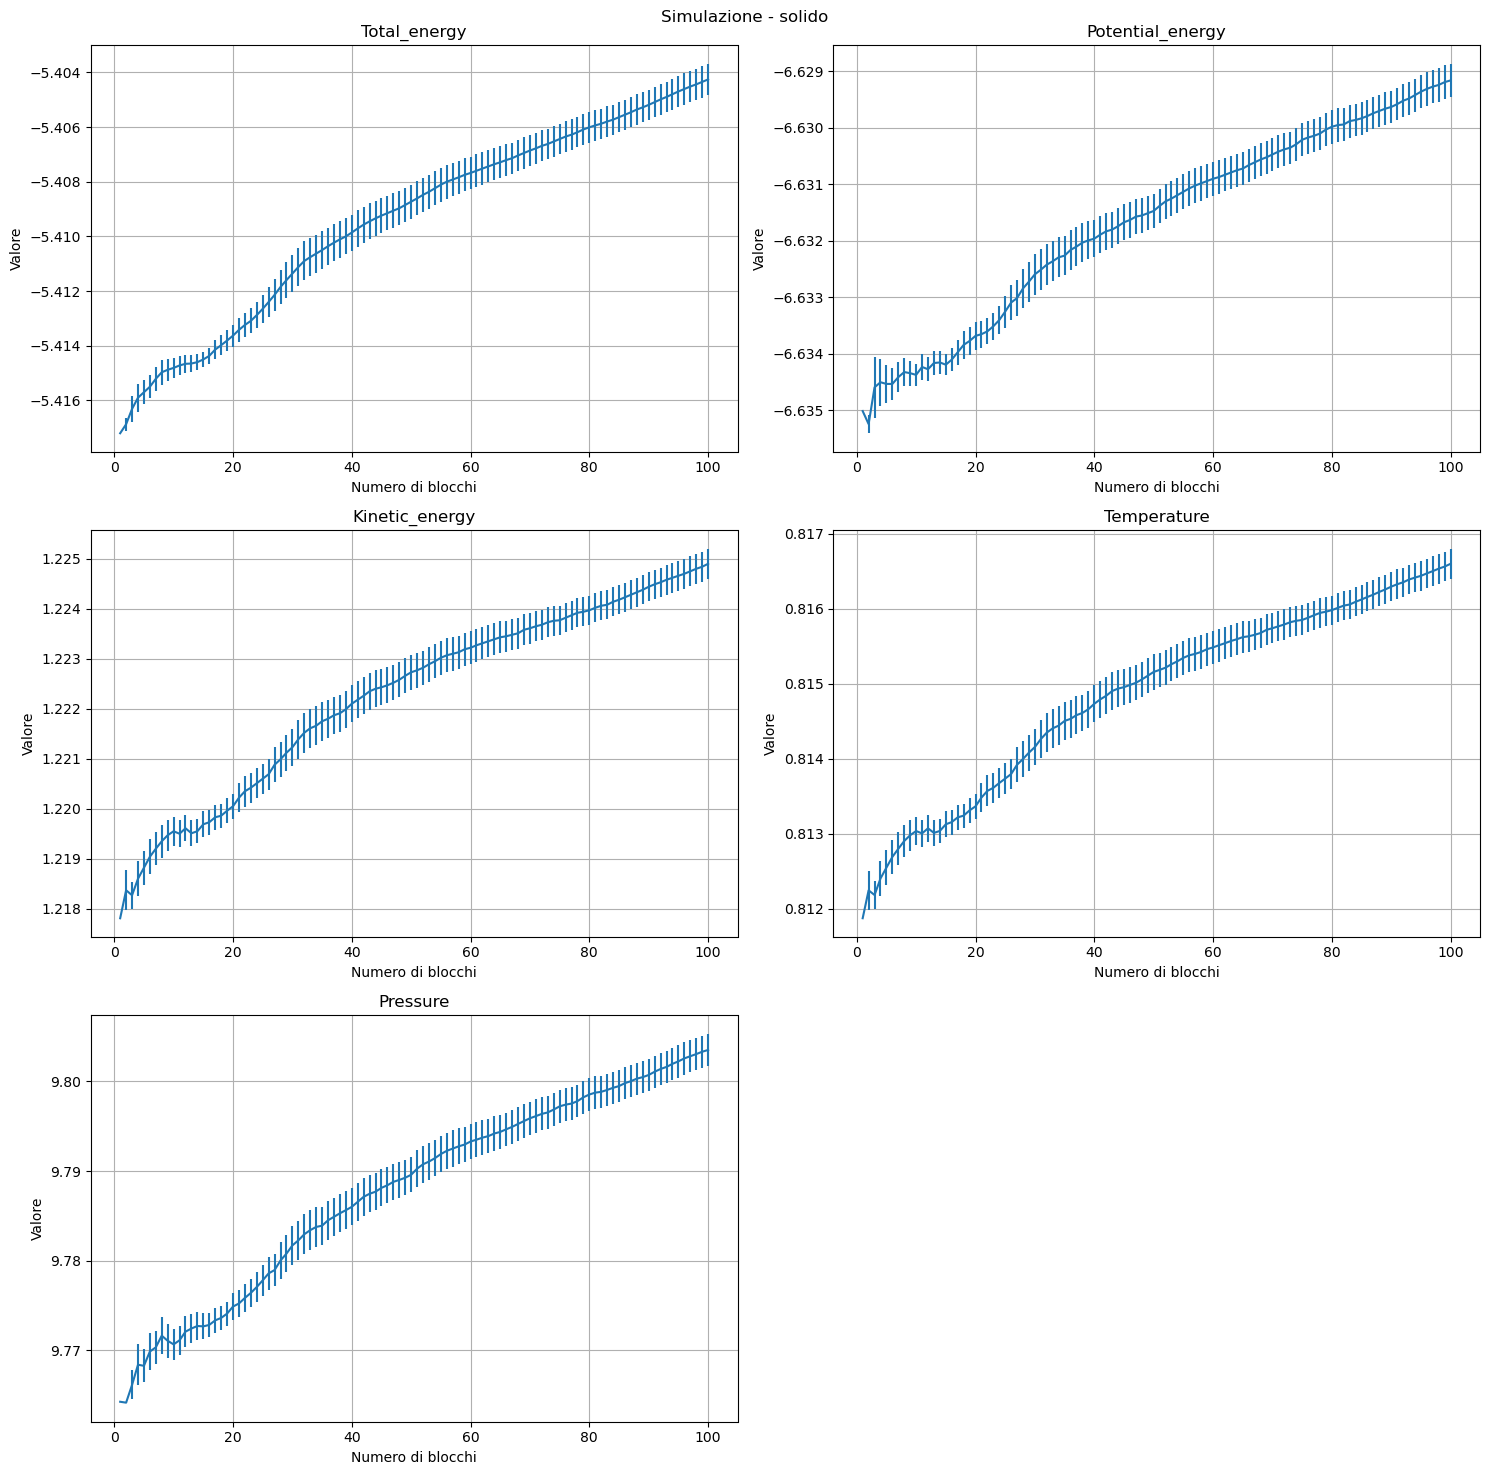

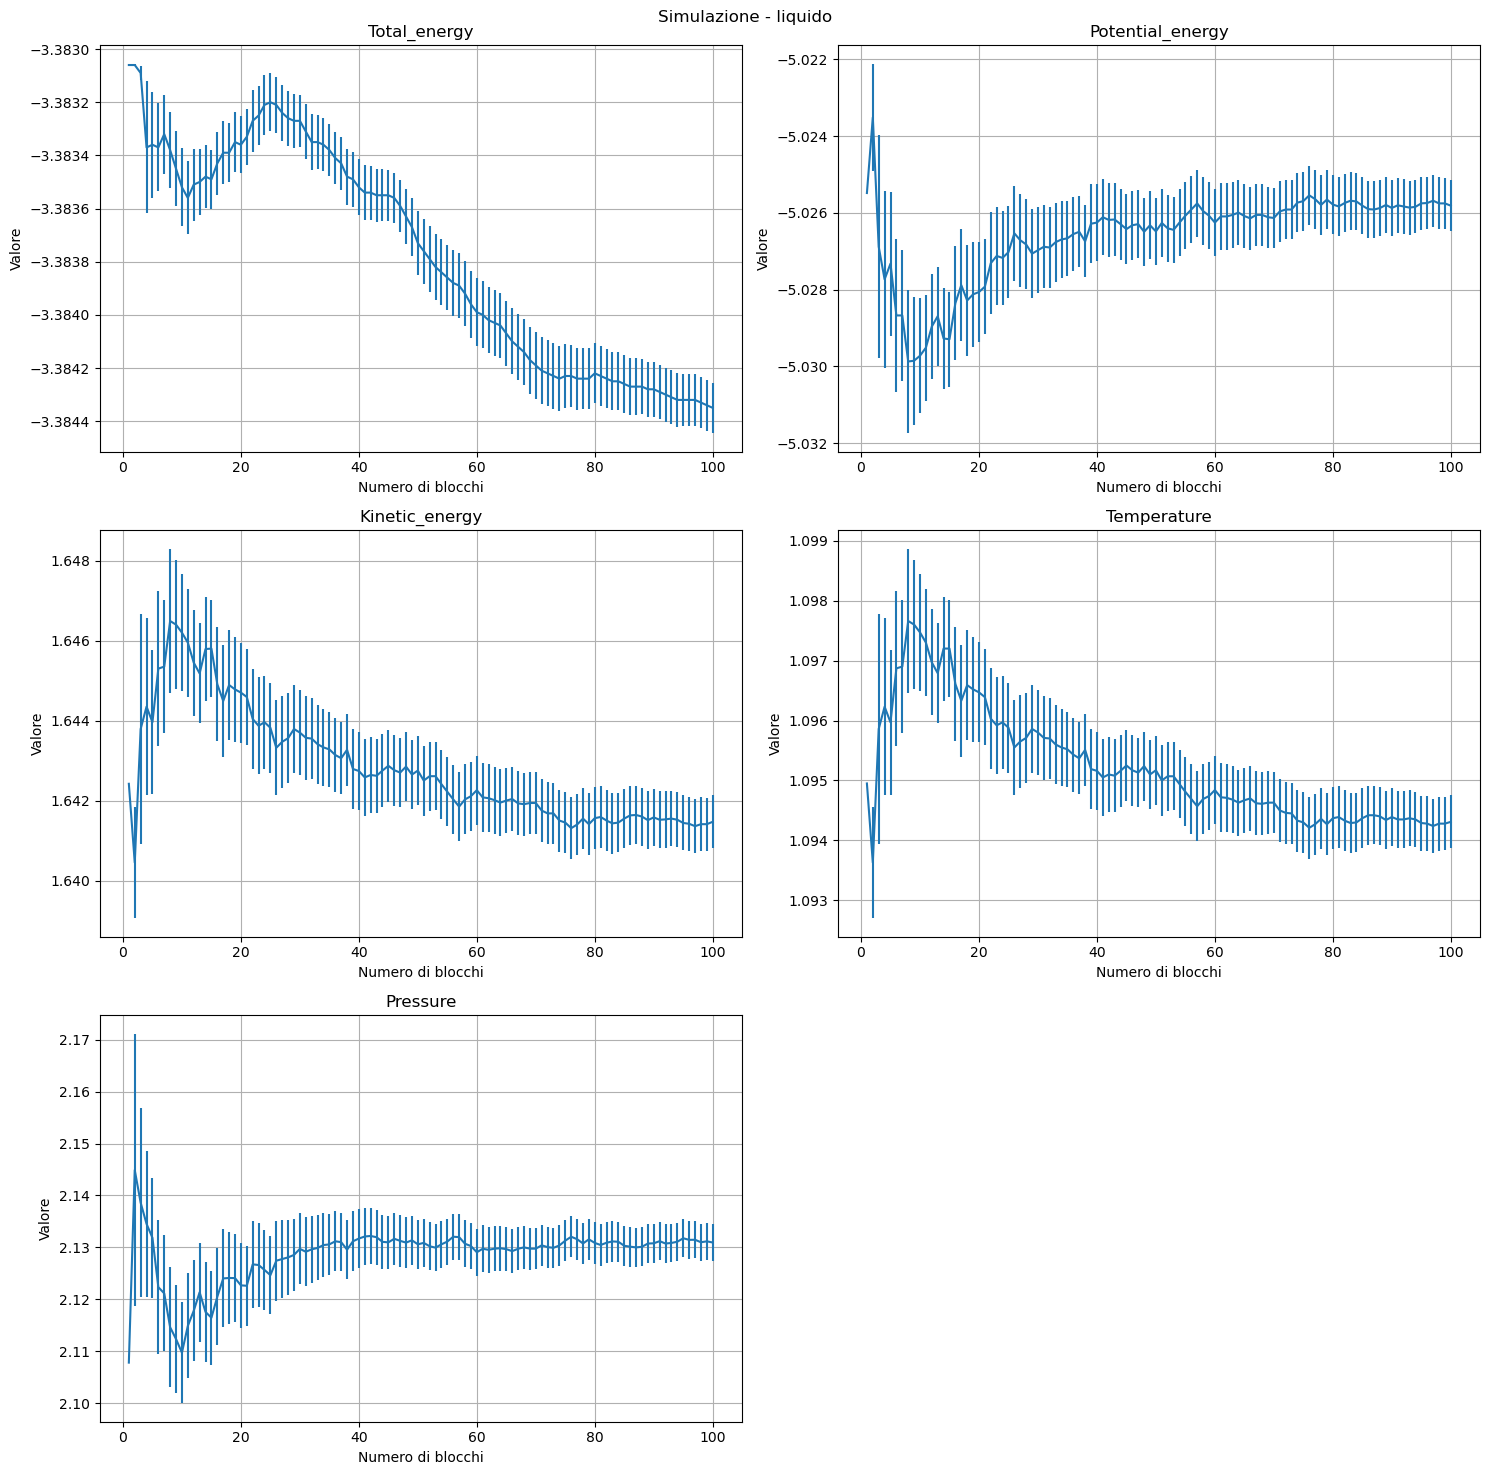

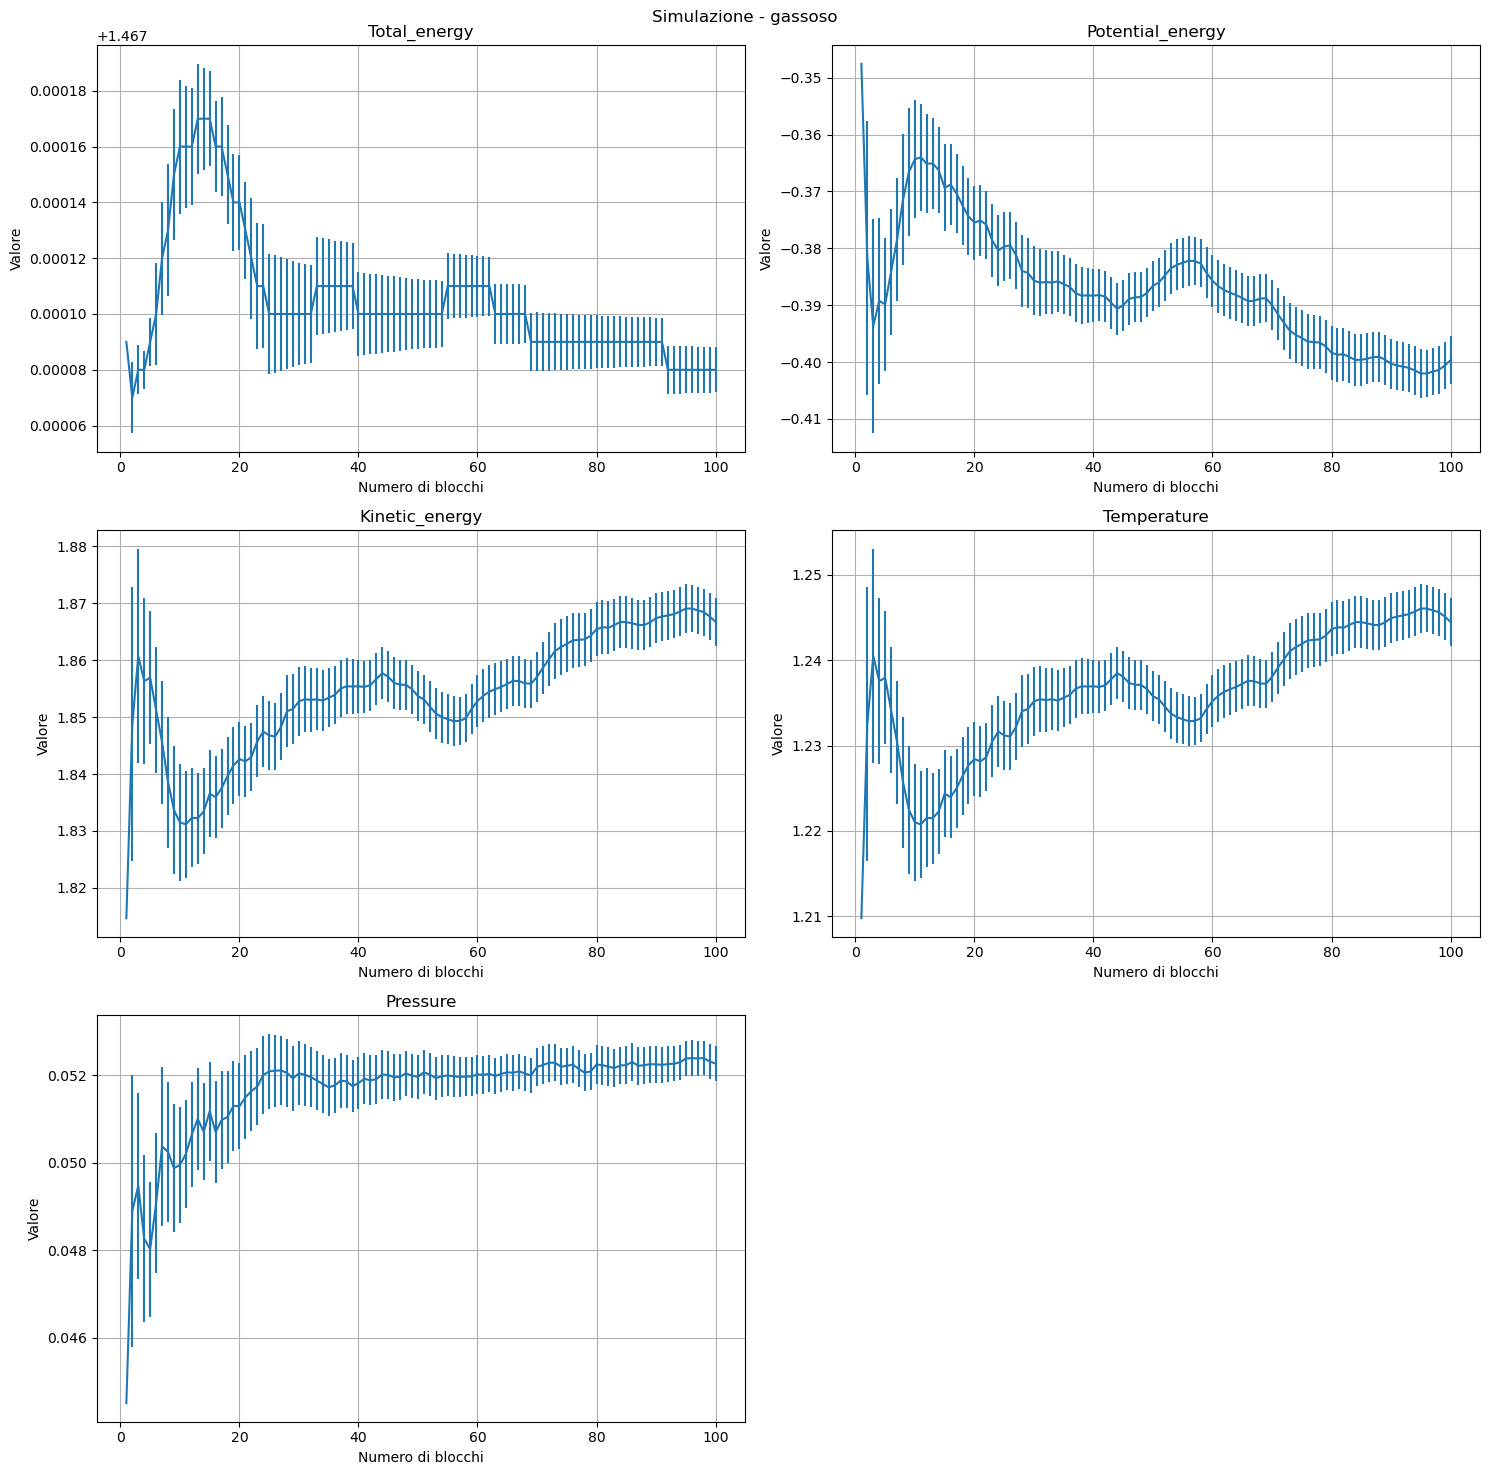

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def read_data_from_file(filename):
    # Inizializza due liste vuote per memorizzare i dati
    nblocchi = []
    media = []
    errore = []

    # Apre il file e legge i dati riga per riga
    with open(filename, 'r') as file:  # Modalità "r" per la lettura
        for line in file:
            if line.startswith('#'):
                continue
            # Divide ogni riga in due numeri e li aggiunge alle rispettive liste
            values = line.split()
            nblocchi.append(float(values[0]))
            media.append(float(values[2]))
            errore.append(float(values[3]))
            
    return nblocchi, media, errore

# Lista dei nomi dei file da leggere per le tre simulazioni
simulations = ["_solido", "_liquido", "_gassoso"]
data_types = ["total_energy", "potential_energy", "kinetic_energy", "temperature", "pressure"]
path = "./nsl_simulator/NSL_SIMULATOR/OUTPUT/"
# Traccia i grafici per ogni simulazione
for simulation in simulations:
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for idx, data_type in enumerate(data_types):
        filename = f"{path}{data_type}{simulation}.dat"
        nblocchi, media, errore = read_data_from_file(filename)
        axes[idx].errorbar(nblocchi, media, yerr=errore)
        axes[idx].set_title(f"{data_type.capitalize()}")
        axes[idx].set_xlabel('Numero di blocchi')
        axes[idx].set_ylabel('Valore')
        axes[idx].grid(True)
    
    # Rimuove l'ultimo subplot vuoto (altrimenti rimarrà una casella vuota)
    fig.delaxes(axes[-1])
    
    fig.suptitle(f"Simulazione - {simulation.capitalize()[1:]}")
    plt.tight_layout()
    plt.show()